In [1]:
import pandas as pd 
import numpy as np
import numpy.ma as ma
import matplotlib.colors 
import matplotlib.pyplot as plt 
import cartopy as cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import harp  
import os
import glob
import matplotlib.dates as mdates
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import os
from collections import OrderedDict
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime
import netCDF4 as nc # netcdf module
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import harp
import os

In [6]:
# Grid TROPOMI data at resolution of 0.1 degrees in a specific ROI (34-45 lat, 18-30 lon) using harp tool --> bin_spatial(111,34,0.1, 121,18,0.1)
product = harp.import_product(r"/Users/Administrator/Desktop/ATC6/NO2/S5P_OFFL_L2__NO2____20230822T105351_20230822T123520_30348_03_020500_20230824T031230.nc", 
operations="tropospheric_NO2_column_number_density_validity>75;keep(latitude_bounds,longitude_bounds,tropospheric_NO2_column_number_density,cloud_fraction,surface_zonal_wind_velocity,surface_meridional_wind_velocity);bin_spatial(111,34,0.1, 121,18,0.1);derive(tropospheric_NO2_column_number_density [Pmolec/cm2])",
post_operations= "bin();squash(time, (latitude_bounds,longitude_bounds));derive(latitude {latitude});derive(longitude {longitude});exclude(latitude_bounds,longitude_bounds,latitude_bounds_weight,longitude_bounds_weight,count,weight)")
u1= product.surface_zonal_wind_velocity.data[0,:]
v1=product.surface_meridional_wind_velocity.data[0,:]
no2= product.tropospheric_NO2_column_number_density.data[0,:]
lon1=product.longitude_bounds.data[:,0]
lat1=product.latitude_bounds.data[:,0]
i_lat1, j_lon1 = np.meshgrid(lat1, lon1, indexing='ij')

In [7]:
# Compute the average of wind field every 2 pixel (too noisy plot with the wind for each single pixel)
u_split1= u1.reshape(55,2,60,2)
u_mean1=np.nanmean(u_split1,axis=(1,3))
v_split1= v1.reshape(55,2,60,2)
v_mean1=np.nanmean(v_split1,axis=(1,3))

lon_split1 = j_lon1.reshape(55,2,60,2)
lon_mean1 = np.nanmean(lon_split1,axis=(1,3))
lat_split1 = i_lat1.reshape(55,2,60,2)
lat_mean1 = np.nanmean(lat_split1,axis=(1,3))

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_9080/2672430306.py:2: RuntimeWarning: Mean of empty slice
  u_mean1=np.nanmean(u_split1,axis=(1,3))
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_9080/2672430306.py:4: RuntimeWarning: Mean of empty slice
  v_mean1=np.nanmean(v_split1,axis=(1,3))


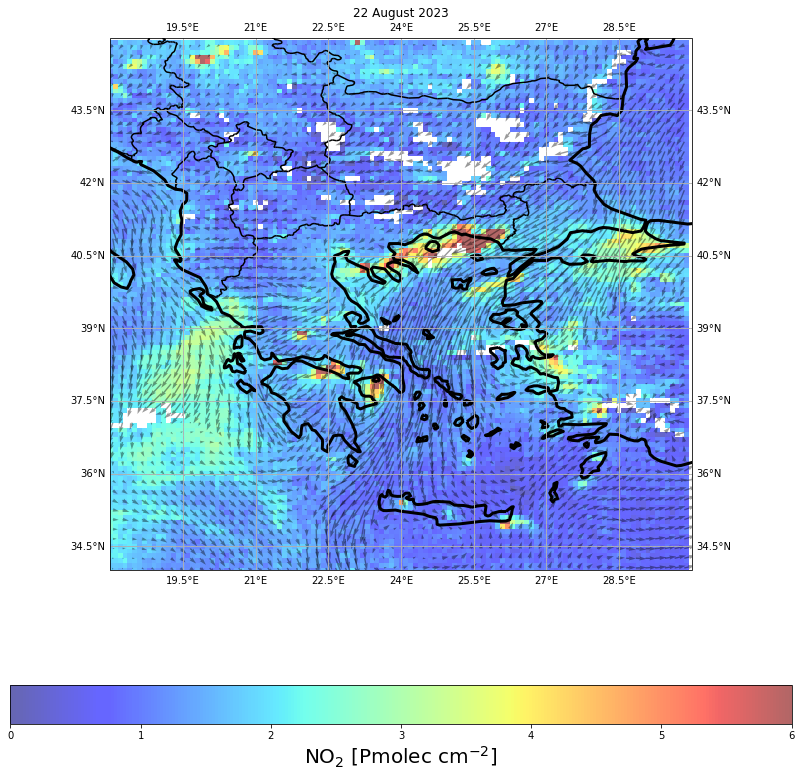

In [8]:
# Plot NO2 with on top the wind field
plt.figure(figsize=(14, 14))
ax = plt.axes(projection=cartopy.crs.PlateCarree(0))
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1,lw=1.5)
ax.coastlines(resolution='50m', lw=3)
ax.gridlines(linestyle='--')
ax.set_extent ((18, 30, 34, 45), cartopy.crs.PlateCarree())
ax.set_title("22 August 2023")
zz = plt.pcolormesh( j_lon1, i_lat1, no2 , cmap='jet', alpha = 0.6,vmin=0, vmax=6)
cb = plt.colorbar(zz,orientation="horizontal")
q = plt.quiver(lon_mean1,lat_mean1, u_mean1, v_mean1,angles='xy', alpha = 0.4, scale=200)
qk = plt.quiverkey(q, 0.5, -0.5, 10, '10 m/s', labelpos='E',coordinates='axes')
cb.set_label('NO$_{2}$ [Pmolec cm$^{-2}$]',fontsize =20)
plt.show()

In [9]:
# Grid Aerosol Index data to spot the fires
product = harp.import_product(r"/Users/Administrator/Desktop/ATC6/AI/S5P_OFFL_L2__AER_AI_20230822T105351_20230822T123520_30348_03_020500_20230824T004731.nc", 
operations= "absorbing_aerosol_index_validity>40;keep(latitude_bounds,longitude_bounds,absorbing_aerosol_index);bin_spatial( 111,34,0.1, 121,18,0.1);derive(absorbing_aerosol_index)",
post_operations= "bin();squash(time, (latitude_bounds,longitude_bounds));derive(latitude {latitude});derive(longitude {longitude});exclude(latitude_bounds,longitude_bounds,latitude_bounds_weight,longitude_bounds_weight,count,weight)")
ai = product.absorbing_aerosol_index.data[:][0,:]

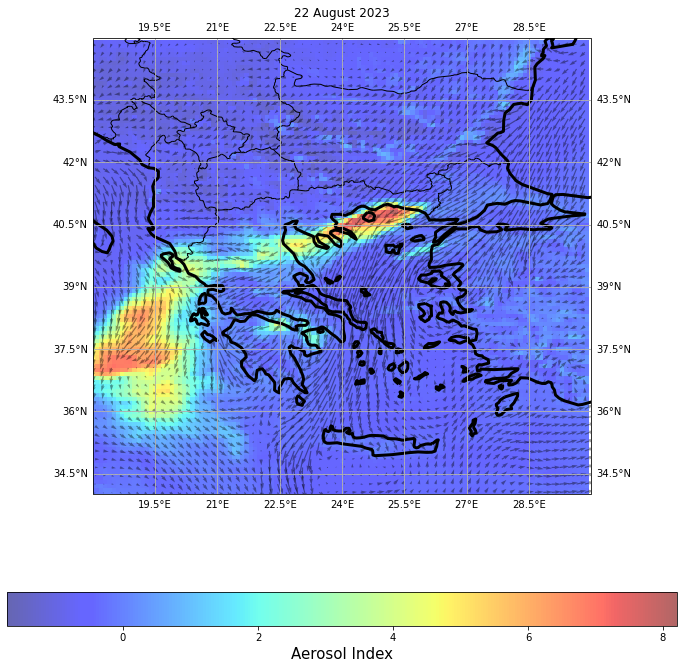

In [10]:
# Plot Aerosol Index and check if the plume is coherent with the wind field
plt.figure(figsize=(12,12))
ax = plt.axes(projection=cartopy.crs.PlateCarree(0))
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.coastlines(resolution='50m', lw=3)
ax.gridlines(linestyle='--')
ax.set_extent ((18, 30, 34, 45), cartopy.crs.PlateCarree())
ax.set_title("22 August 2023")
zz = plt.pcolormesh( j_lon1, i_lat1, ai, cmap='jet', alpha = 0.6 )
q = plt.quiver(lon_mean1,lat_mean1, u_mean1, v_mean1,angles='xy', alpha = 0.4, scale=200)
qk = plt.quiverkey(q, 0.5, -0.5, 10, '10 m/s', labelpos='E',coordinates='axes')
cb = plt.colorbar(zz,orientation="horizontal")
cb.set_label('Aerosol Index',fontsize =15)
plt.show()

In [11]:
# Grid CO data
product = harp.import_product(r"/Users/Administrator/Desktop/ATC6/NO/S5P_OFFL_L2__CO_____20230822T105351_20230822T123520_30348_03_020500_20230824T004722.nc",
operations='CO_column_number_density_validity>50;derive(CO_column_volume_mixing_ratio {time} [ppbv]);keep(latitude_bounds,longitude_bounds,CO_column_volume_mixing_ratio);bin_spatial(111,34,0.1, 121,18,0.1)',
post_operations='bin();squash(time, (latitude_bounds,longitude_bounds));derive(latitude {latitude});derive(longitude {longitude});exclude(latitude_bounds,longitude_bounds,latitude_bounds_weight,longitude_bounds_weight,count,weight)')
co=product.CO_column_volume_mixing_ratio.data[0,:]

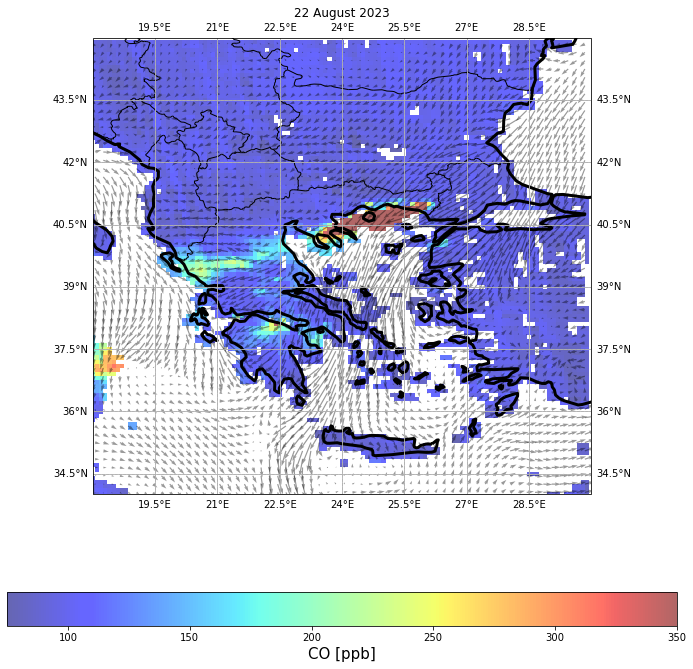

In [12]:
# Plot the CO and the wind field to detect the fires emissions
plt.figure(figsize=(12,12))
ax = plt.axes(projection=cartopy.crs.PlateCarree(0))
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1)
ax.coastlines(resolution='50m', lw=3)
ax.gridlines(linestyle='--')
ax.set_extent ((18, 30, 34, 45), cartopy.crs.PlateCarree())
ax.set_title("22 August 2023")
zz = plt.pcolormesh( j_lon1, i_lat1, co, cmap='jet', alpha = 0.6,vmin=75, vmax=350 )
q = plt.quiver(lon_mean1,lat_mean1, u_mean1, v_mean1,angles='xy', alpha = 0.4, scale=200)
qk = plt.quiverkey(q, 0.5, -0.5, 10, '10 m/s', labelpos='E',coordinates='axes')
cb = plt.colorbar(zz,orientation="horizontal")
cb.set_label('CO [ppb]',fontsize =15)
plt.show()